# Thermal Infrared Remote Sensing of Snow

:::{admonition} Learning Objectives

**At the conclusion of this tutorial, you will be able to:**
- understand the differences between sources of thermal IR observations, the advantages and disadvantages of each, and types of research questions we can address with those observations
- visualize point and raster thermal infrared datasets together, then compute error statistics between point and raster datasets
- access and visualize airborne and satellite thermal infrared imagery, then scale imagery of different spatial resolutions for comparison

:::

**Download the sample datasets for this tutorial**

For ease of access during the hackweek, sample files are available for download for running the command in the cell below. (See the bonus notebook "[thermal-ir-data-download.ipynb](thermal-ir-data-download.ipynb)" for more details about data access methods)

In [1]:
!aws s3 sync --quiet s3://snowex-data/tutorial-data/thermal-ir/ /tmp/thermal-ir/

**Import the packages we'll need for this tutorial**

In [2]:
# Import some general-purpose packages for handling different data structures
import numpy as np # for working with n-D arrays
import pandas as pd # for reading our csv data file and working with tabular data

# Import matplotlib which we'll use for plotting images and graphs
import matplotlib.pyplot as plt

# Import these packages for working with raster data
import xarray as xr # xarray lets us work with n-D arrays and labeled data, such as NetCDF files
import rioxarray # rioxarray provides capabilities of the rasterio package to xarray, letting us easily work with files such as GeoTIFFs

# Import some packages for working with the SnowEx SQL database
from snowexsql.db import get_db # Import the connection function from the snowexsql library
from  snowexsql.data import SiteData # Import the table classes from our data module which is where our ORM classes are defined 
from datetime import date # Import some tools to build dates 
from snowexsql.conversions import query_to_geopandas # Import a useful function for plotting and saving queries! See https://snowexsql.readthedocs.io/en/latest/snowexsql.html#module-snowexsql.conversions

---

# Part 1: Comparing airborne IR imagery with ground-truth observations

## Airborne IR imagery

(explain how we collected these over grand mesa)



<figure>
  <img src="figures/twinotter1.JPG" width="600" />
  <figcaption><b>Fig. 1</b> The Naval Postgraduate School Twin Otter aircraft carried the UW APL thermal infrared imager and SWESARR instrument over Grand Mesa for SnowEx 2020.<br/>(Photo by Chris Chickadel)</figcaption>
</figure>

Load IR image mosaic netcdf file

In [3]:
airborne_ir = xr.open_rasterio('/tmp/thermal-ir/SNOWEX2020_IR_PLANE_2020Feb08_mosaicked_2020-02-08T181915.tif')

Inspect the contents of the file we just opened

In [4]:
airborne_ir

<xarray.DataArray (band: 1, y: 3848, x: 4398)>
[16923504 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.332e+06 4.332e+06 4.332e+06 ... 4.313e+06 4.313e+06
  * x        (x) float64 7.371e+05 7.371e+05 7.371e+05 ... 7.591e+05 7.591e+05
Attributes:
    transform:      (4.9992529765780835, 0.0, 737077.3666563785, 0.0, -4.9992...
    crs:            +init=epsg:32612
    res:            (4.9992529765780835, 4.99925297657805)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('STCtemp',)
    AREA_OR_POINT:  Area
    description:    Airborne thermal infrared imagery from University of Wash...
    grid_mapping:   spatial_ref

In [5]:
airborne_ir.rio.crs # original CRS

CRS.from_epsg(32612)

Under the dataarray's attributes we can see that we have a coordinate reference system already defined (crs) as [EPSG:32612](https://epsg.io/32612). We can also find this through `da.rio.crs`. 

However, we would like to reproject this into the common projection used by datasets on the SnowEx SQL database: [EPSG:26912](https://epsg.io/26912). We can do that using rioxarray's [reproject](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray.raster_array.RasterArray.reproject) method (see an example [here](https://corteva.github.io/rioxarray/stable/examples/reproject.html)).

In [6]:
airborne_ir = airborne_ir.rio.reproject('EPSG:26912') # overwrite itself with new reprojected data array

In [7]:
airborne_ir.rio.crs # new CRS

CRS.from_epsg(26912)

Next, the filename shows us when this imagery was taken in UTC time, "2020-02-08T181915"

We can create a pandas timestamp variable in local time for comparison with other datasets:

In [8]:
# Create a pandas timestamp, subtract 7 hours from UTC time to get local time (MST, UTC-7)
airborne_ir_timestamp = pd.Timestamp(2020,2,8,18,19,15) - pd.Timedelta(hours=7)

:::{admonition} What color scale should we use for temperature?
:class: dropdown 

Common advice you may have heard is to [avoid using rainbow color scales](https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/). Luckily [matplotlib gives us lots of options](https://matplotlib.org/stable/tutorials/colors/colormaps.html) to choose from.

When representing images of temperature, sometimes we want to pick colors that intuitively suggest temperature, such as the "magma" colorbar below. Other times we might be interested in both magnitude and sign, such as temperatures above or below melting point, in which case we could use something like "RdBu_r" below. I often pick simple greyscale, though less visually interesting, it is sometimes easier to pick out details in a continuous color scale like they "Greys" scale below. **Make sure to include a labeled colorbar so your plot can be correctly interpreted!**

<figure>
  <img src="figures/colorbars.png" width="300"/>
  <figcaption><b>Fig. 2</b> Some matplotlib color scale options (top to bottom): "magma", "RdBu_r", "Greys"</figcaption>
</figure>

:::

Plot the airborne TIR image. 
* What does our chosen colorscale tell us about temperatures here?
* What can we see? 

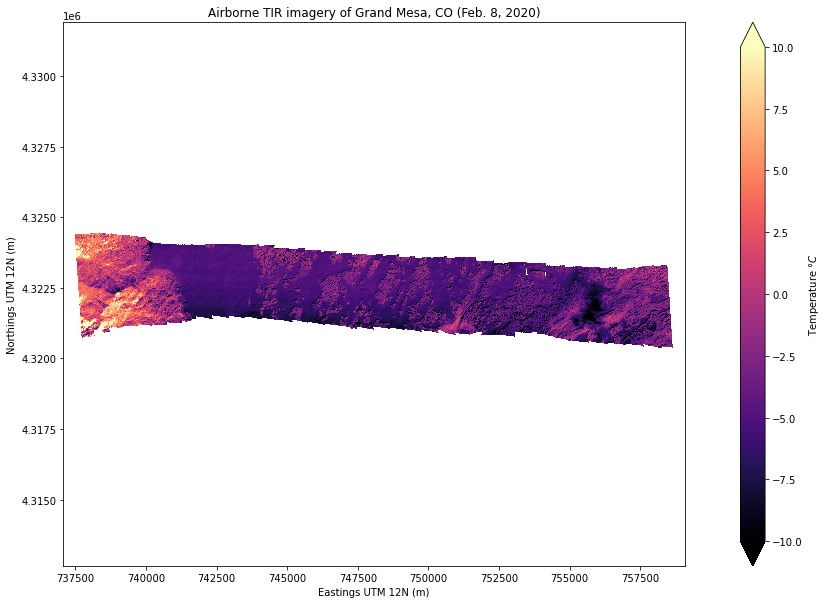

In [9]:
fig, ax = plt.subplots(figsize=(20,10)) # create a new matplotlib figure, set the figure size
ax.set_aspect('equal') # set the aspect ratio to "equal"

# plot the airborne infrared image
airborne_ir.plot(cmap='magma', vmin=-10, vmax=10,ax=ax, 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})

# set axes labels
ax.set_xlabel('Eastings UTM 12N (m)')
ax.set_ylabel('Northings UTM 12N (m)')

ax.set_title('Airborne TIR imagery of Grand Mesa, CO (Feb. 8, 2020)');

:::{admonition} Image interpretation
:class: hint
* What does our chosen colorscale tell us about temperatures here?
  * The colorbar on the right shows us that colder temperatures are represented with dark purple to black colors.
  * Warmer temperatures are represented with lighter orange/yellow.
* What can we see?
  * We see a narrow stripe of imagery, this is a mosaic of individual camera images taken from the aircraft along a single flight line over Grand Mesa.
  * On the left (west) side of the image we see warmer but varied temperatures (yellow, orange, and purple), then an abrupt transition to uniformly cold temperatures (purple). This is the westernmost edge of the mesa where the snow on top is much colder than the lower elevation slopes of the mountain.
  * Continuing to move from left (west) to right (east) we see patches of lighter colors, corresponding with warmer temperatures. These are patches of forest on the central and eastern portions of the mesa.
  * Finally near the easternmost side of the image we see a very dark region that means it is much colder than the rest of the scene. What might this cold area or object be?
:::

## Bonus activity:
To help with our image interpretation, we can load visible imagery taken concurrently from the UW-APL airborne instrument. (Note: this example image is a single band black and white image, though we also have full RGB images available through NSIDC)

In [10]:
airborne_vis = xr.open_rasterio('/tmp/thermal-ir/SNOWEX2020_EO_PLANE_2020Feb08_mosaicked_2020-02-08T181915.tif')

# note that the filename is identical with the same timestamp, but is labeled "EO" (electro-optical) rather than "IR" (infrared)

In [11]:
airborne_vis

<xarray.DataArray (band: 1, y: 3848, x: 4398)>
[16923504 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.332e+06 4.332e+06 4.332e+06 ... 4.313e+06 4.313e+06
  * x        (x) float64 7.371e+05 7.371e+05 7.371e+05 ... 7.591e+05 7.591e+05
Attributes: (12/13)
    transform:      (4.9992529765780835, 0.0, 737077.3666563785, 0.0, -4.9992...
    crs:            +init=epsg:32612
    res:            (4.9992529765780835, 4.99925297657805)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    ...             ...
    descriptions:   ('SRGB',)
    AREA_OR_POINT:  Area
    description:    visible imagery
    grid_mapping:   spatial_ref
    timezone:       time in UTC
    units:          digital numbers

Plot the visible and infrared images side by side. This time, we will change the x and y axes limits ([set_xlim](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlim.html), and [set_ylim](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_ylim.html)) to zoom in closer.

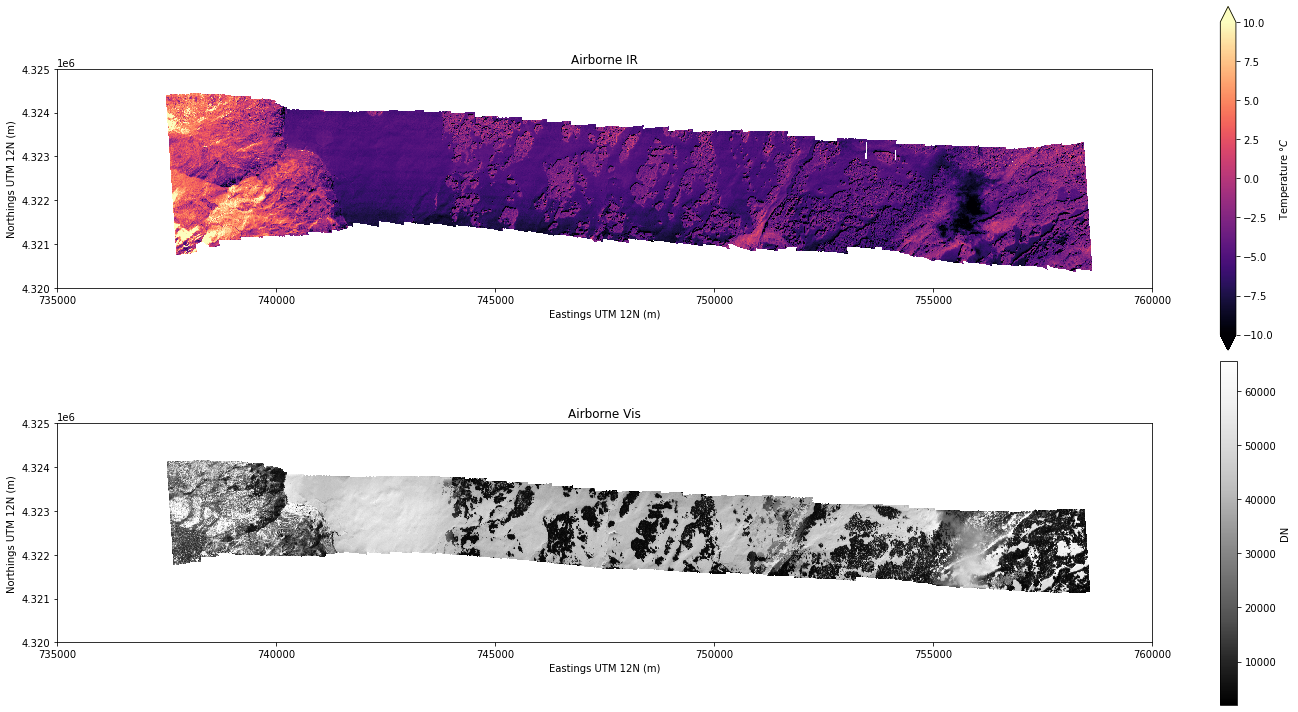

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,10), tight_layout=True)

# Plot the IR imagery
airborne_ir.plot(ax=axs[0], 
                 cmap='magma', 
                 vmin=-10, vmax=10, 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})
axs[0].set_title('Airborne IR')

# Plot the visible imagery
airborne_vis.plot(ax=axs[1], 
                  cmap='Greys_r',
                  cbar_kwargs={'label': 'DN'})
axs[1].set_title('Airborne Vis')

# for each subplot, do the following:
for ax in axs: 
    ax.set_aspect('equal') # set the aspect ratio to "equal"
    
    # give each axis a label
    ax.set_xlabel('Eastings UTM 12N (m)')
    ax.set_ylabel('Northings UTM 12N (m)')
    
    # set the axes limits, units in meters UTM Zone 12N (I chose these values by just looking at the plot above)
    ax.set_xlim((735000, 760000)) # x axis limits
    ax.set_ylim((4320000, 4325000)) # y axis limits

:::{admonition} Image interpretation
:class: hint
* The visible imagery camera covers a slightly narrower width along the flight path than the IR cameras.
* Now what do you think the cold object on the eastern side of the image is?
:::

---

## Ground-based temperature observations

To provide a source of "ground truth" for the airborne and satellite thermal infrared images during the SnowEx 2020 Grand Mesa campaign, we can use ground-based snow surface temperature measurements. On February 5, 2020, we installed a thermal infrared radiometer pointing at the snow surface at snow pit #2S10 (left), and buried temperature sensors beneath the snow surface (right). These logged observations at 5-minute intervals until we removed the instrumentation a week later on February 12.

<figure>
  <img src="figures/snowpit_2s10.png" width="600"/>
  <figcaption><b>Fig. 3</b> Snow temperature sensor setup at snow pit 2S10: (left) tripod-mounted thermal ifrared radiometer to measure snow surface, (right) temperature probes to be burried beneath the snow surface.<br/>(Photos by Steven Pestana)</figcaption>
</figure>

:::{admonition} What are some of the differences we might expect to see between the ground-based surface temperature data and the thermal IR images?
:class: dropdown
 - *Emissivity differences?* 
   - Our ground-based radiometer was looking at 45 deg off nadir, versus nadir ASTER versus variable view angle airborne (snow emissivity changes off-nadir)
 - *Different TIR bandwidths (broad versus narrow)?* 
   - Ground-based radiometer: 8-14 μm, Airborne IR cameras: 8-14 μm, ASTER band 14: 10.95-11.65 µm
 - *Different atmospheric path lengths?* 
   - From <1 meter, to 1 km, to entire atmospheric column (~100 km)
 - *"Point" versus area, and geolocation accuraccy*
   - The ground-based radiometer is measuring temperature for a spot (not really a single point) maybe ~1m in diameter. The airborne and ASTER imagers have spatial resolutions of 5m and 90m respectively. How confident are we in the geolocation of individual pixels in the imagery?

:::




**Where is snow pit 2S10?**

We can find this information through a query to the SnowEx SQL database. First, set up the connection:

In [13]:
# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@52.32.183.144/snowex'
# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

Then, query [SiteData](https://snowexsql.readthedocs.io/en/latest/database_structure.html#sites-table) using [filter_by](https://docs.sqlalchemy.org/en/14/orm/query.html#sqlalchemy.orm.Query.filter_by) to find the entry with the site ID that we want (2S10). Preview the resulting geodataframe.

In [14]:
# Form the query to receive site_id='2S10' from the sites table
qry = session.query(SiteData).filter_by(site_id='2S10')

# Convert the record received into a geopandas dataframe
siteData_df = query_to_geopandas(qry, engine)

# Preview the resulting geopandas dataframe
siteData_df

,site_name,date,time_created,time_updated,id,site_id,doi,date_accessed,latitude,longitude,...,weather_description,precip,sky_cover,wind,ground_condition,ground_roughness,ground_vegetation,vegetation_height,tree_canopy,site_notes
0,Grand Mesa,2020-02-05,2021-06-01 18:41:44.586420+00:00,None,115,2S10,https://doi.org/10.5067/DUD2VZEVBJ7S,None,39.019474,-108.192314,...,"Sunny and cold, some blowing snow",None,Few (< 1/4 of sky),Moderate,Frozen,Rough,"Grass, Shrub","20, 30",No Trees,None


In [15]:
# Preview the geometry of this geodataframe, we should see that it is a POINT
siteData_df.geometry

0    POINT (743076.000 4322689.000)
Name: geom, dtype: geometry

We can now plot our snow pit site from this [geodataframe](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.plot.html) on top of the airborne IR image. (See more tips about plotting geodataframes [here](https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-vector-plots/python-change-spatial-extent-of-map-matplotlib-geopandas/))



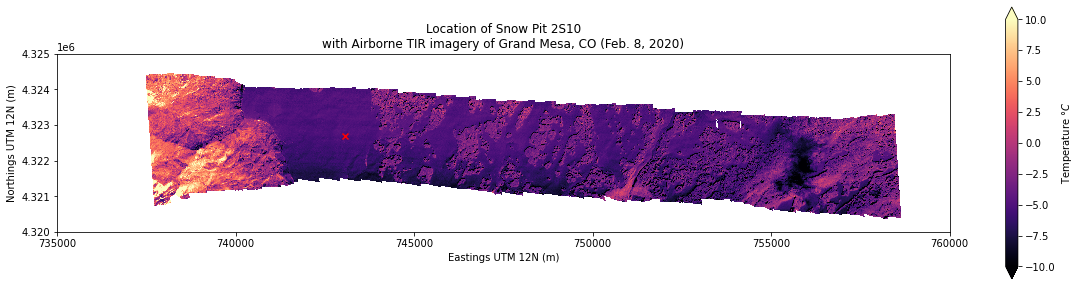

In [16]:
fig, ax = plt.subplots(figsize=(20,5)) # create a new matplotlib figure, set the figure size
ax.set_aspect('equal') # set the aspect ratio to "equal"

# plot the airborne infrared image
airborne_ir.plot(cmap='magma', vmin=-10, vmax=10, ax=ax, 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})

# plot the location of the snow pit of interest
siteData_df.plot(ax=ax, color='r', marker='x')

# set axes labels
ax.set_xlabel('Eastings UTM 12N (m)')
ax.set_ylabel('Northings UTM 12N (m)')

# set the axes limits, units in meters UTM Zone 12N (I chose these values by just looking at the plot above)
ax.set_xlim((735000, 760000)) # x axis limits
ax.set_ylim((4320000, 4325000)) # y axis limits

# set plot title
ax.set_title('Location of Snow Pit 2S10\nwith Airborne TIR imagery of Grand Mesa, CO (Feb. 8, 2020)');

Change the x and y axes limits ([set_xlim](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlim.html), and [set_ylim](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_ylim.html)) to zoom in to our point of interest. In this case we can use [df.geometry.total_bounds](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.GeoSeries.total_bounds.html) to get the x and y values that define the area our geometry takes up. (In this case we have a point so it will return just the point's location, but this would work if we had a polygon as well)

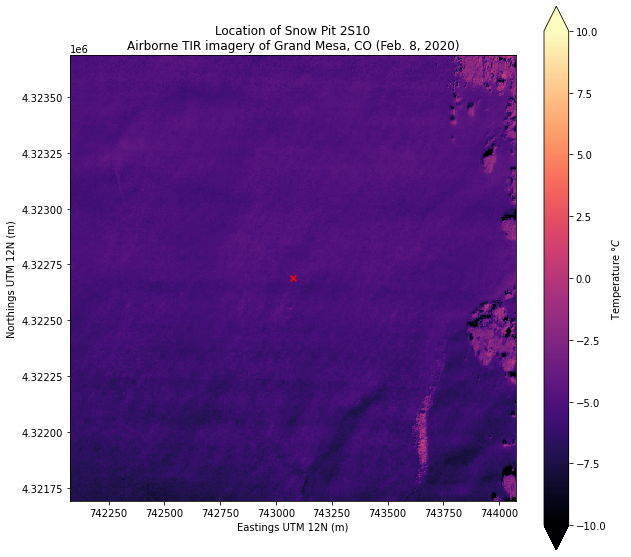

In [17]:
fig, ax = plt.subplots(figsize=(10,10)) # create a new matplotlib figure, set the figure size
ax.set_aspect('equal') # set the aspect ratio to "equal"

# plot the airborne infrared image
airborne_ir.plot(cmap='magma', vmin=-10, vmax=10, ax=ax, 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})

# plot the location of the snow pit of interest
siteData_df.plot(ax=ax, color='r', marker='x')

# set axes limits
xmin, ymin, xmax, ymax = siteData_df.geometry.total_bounds # get the "total bounds" for our geometry
ax.set_xlim((xmin-1000, xmax+1000)) # x axis limits to +/- 1 km from our point's "total bounds"
ax.set_ylim((ymin-1000, ymax+1000)) # y axis limits to +/- 1 km from our point's "total bounds"

# set axes labels
ax.set_xlabel('Eastings UTM 12N (m)')
ax.set_ylabel('Northings UTM 12N (m)')

# set plot title
ax.set_title('Location of Snow Pit 2S10\nAirborne TIR imagery of Grand Mesa, CO (Feb. 8, 2020)');

**Import the snow temperature timeseries dataset**

This data is [availible through NSIDC](https://nsidc.org/data/SNEX20_VPTS_Raw/versions/1), but we have already downloaded a local copy for this tutorial. (See the bonus notebook "[thermal-ir-data-download.ipynb](thermal-ir-data-download.ipynb)" for more details about data access methods)

The raw data file doesn't include the column names, so we need to set the column headers following the dataset's README file.

In [18]:
!cat /tmp/thermal-ir/SNEX20_VPTS_Raw/Level-0/snow-temperature-timeseries/README.txt

Description:
	This folder contains data files from two Campbell Scientific CR10X dataloggers which were installed at two sites on Grand Mesa to measure snow temperature profiles as part of the SnowEx 2020 field campaign.
	
	"Grand Mesa 1" (GM1) measured snow surface temperature with an Apogee SI-111 thermal infrared radiometer mounted on a tripod at a height of about 127 cm above the snow surface. The radiometer pointed 45 degrees off-nadir at the snow surface just to the west of the tripod. Five Campbell Scientific temperature probes were mounted vertically along a wooden stake with zip ties, at depths of 5, 10, 15, 20, and 30 cm below the snow surface. (CR10X_GM1_final_storage_1.dat) 
	
	"Grand Mesa 2" (GM2) measured snow temperatures with five temperature probes mounted vertically on a wooden stake with zip ties at depths of 5, 10, 15, 20, and 30 cm below the snow surface. This location was just outside the fence perimeter of the Mesa West met station (northwest of the met station t

Create a list of column headers according to the readme above (for "GM1" which we can read was the datalogger at snowpit 2S10)

In [19]:
column_headers = ['table', 'year', 'doy', 'time', # year, day of year, time of day (local time, UTC-7)
                  'rad_avg', 'rad_max', 'rad_min', 'rad_std', # radiometer surface temperature
                  'sb_avg', 'sb_max', 'sb_min', 'sb_std', # radiometer sensor body temperature (for calibration)
                  'temp1_avg', 'temp1_max', 'temp1_min', 'temp1_std', # temperature at 5 cm below snow surface
                  'temp2_avg', 'temp2_max', 'temp2_min', 'temp2_std', #               10 cm
                  'temp3_avg', 'temp3_max', 'temp3_min', 'temp3_std', #               15 cm
                  'temp4_avg', 'temp4_max', 'temp4_min', 'temp4_std', #               20 cm
                  'temp5_avg', 'temp5_max', 'temp5_min', 'temp5_std', #               30 cm
                  'batt_a','batt_b', # battery voltage data
                 ]

Open the file as a pandas data frame with [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

In [20]:
df = pd.read_csv('/tmp/thermal-ir/SNEX20_VPTS_Raw/Level-0/snow-temperature-timeseries/CR10X_GM1_final_storage_1.dat',
                 header = None, names = column_headers) 

# After the filepath we specify header=None because the file doesn't contain column headers, 
# then we specify names=column_headers to give our own names for each column.

We need to do some formatting of the data fields, but we can preview what we just loaded fist

In [21]:
df.head() # show the first 5 rows of the dataframe

,table,year,doy,time,rad_avg,rad_max,rad_min,rad_std,sb_avg,sb_max,...,temp4_avg,temp4_max,temp4_min,temp4_std,temp5_avg,temp5_max,temp5_min,temp5_std,batt_a,batt_b
0,101,2020,30,1537,22.963,22.963,22.963,0.000,22.832,22.832,...,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,22.96,22.83
1,101,2020,30,1538,22.962,22.963,22.961,0.001,22.832,22.832,...,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,22.96,22.83
2,101,2020,30,1539,25.080,26.810,22.968,1.484,22.832,22.832,...,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,24.47,22.83
3,101,2020,30,1540,25.320,25.569,25.133,0.184,22.839,22.846,...,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,25.42,22.85
4,102,2020,30,1540,12.050,0.000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Data cleanup and formatting

In [22]:
# Create a zero-padded time string (e.g. for 9:30 AM we are changing '930' into '0930')
df['time_str'] = [('0' * (4 - len(str(df.time[i])))) + str(df.time[i]) for i in range(df.shape[0])]
# change midnight from '2400' to '0000'
df.time_str.replace('2400', '0000', inplace=True)

This function lets us convert year and day of year (the format that the datalogger uses) to a pandas [datetime index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html):

In [23]:
def compose_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
                 seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    '''Compose a datetime object from various datetime components. This clever solution is from:
        https://stackoverflow.com/questions/34258892/converting-year-and-day-of-year-into-datetime-index-in-pandas'''
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

In [24]:
# Create a datetime value from the date field and zero-padded time_str field, set this as our dataframe's index
df.index = compose_date(df['year'], 
                        days=df['doy'], 
                        hours=df['time_str'].str[:2],
                        minutes=df['time_str'].str[2:])

# Remove entries that are from table "102" (this contains datalogger battery information we're not interested in at the moment)
df = df[df.table != 102]

# drop the columns we no longer need
df.drop(columns=['table','year','doy','time','time_str','batt_a','batt_b'], inplace=True)

Inspect the contents

In [25]:
df.head()

,rad_avg,rad_max,rad_min,rad_std,sb_avg,sb_max,sb_min,sb_std,temp1_avg,temp1_max,...,temp3_min,temp3_std,temp4_avg,temp4_max,temp4_min,temp4_std,temp5_avg,temp5_max,temp5_min,temp5_std
2020-01-30 15:37:00,22.963,22.963,22.963,0.000,22.832,22.832,22.832,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:38:00,22.962,22.963,22.961,0.001,22.832,22.832,22.832,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:39:00,25.080,26.810,22.968,1.484,22.832,22.832,22.832,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:40:00,25.320,25.569,25.133,0.184,22.839,22.846,22.832,0.005,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:41:00,24.894,25.069,24.611,0.182,22.860,22.860,22.860,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0


Make a simple plot of the data. We are interested in the variable `rad_avg` which is the average temperature measured by the radiometer over each 5 minute period.

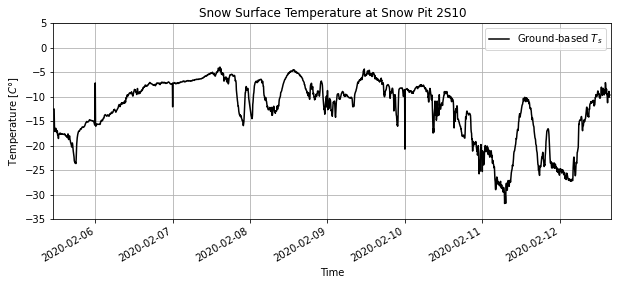

In [26]:
plt.figure(figsize=(10,4))

# plot radiometer average temperature
df.rad_avg.plot(linestyle='-', marker='', markersize=1, c='k', label='Ground-based $T_s$')

# set axes limits
plt.ylim((-35,5))
plt.xlim((pd.Timestamp(2020,2,5,11,0),pd.Timestamp(2020,2,12,16,0)))

# add a legend to the plot
plt.legend()

# set axes labels
plt.ylabel('Temperature [$C\degree$]')
plt.xlabel('Time')

# add grid lines to the plot
plt.grid('on')

# set the plot title
plt.title('Snow Surface Temperature at Snow Pit 2S10');

:::{admonition} Bonus plot: look at snow temperatures below the snow surface
:class: dropdown 

Add the following to the above plot to add lines for temperature recorded at each depth interval below the snow surface:

```
# plot the snow temperature at each depth it was measured
df.temp1_avg.plot(linestyle='-', marker='.', markersize=1, c=[0.8,0.8,1], label='Ts @ -5 cm')
df.temp2_avg.plot(linestyle='-', marker='.', markersize=1, c=[0.6,0.6,1], label='Ts @ -10 cm')
df.temp3_avg.plot(linestyle='-', marker='.', markersize=1, c=[0.4,0.4,1], label='Ts @ -15 cm')
df.temp4_avg.plot(linestyle='-', marker='.', markersize=1, c=[0.2,0.2,1], label='Ts @ -20 cm')
df.temp5_avg.plot(linestyle='-', marker='.', markersize=1, c=[0,0,1], label='Ts @ -30 cm')
```

:::

But then we want to focus on the date/time when our IR image was from, so zoom in on Feb 8th by changing our plot's [xlim](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlim.html) (using pandas [Timestamps](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html) for the x axis values).


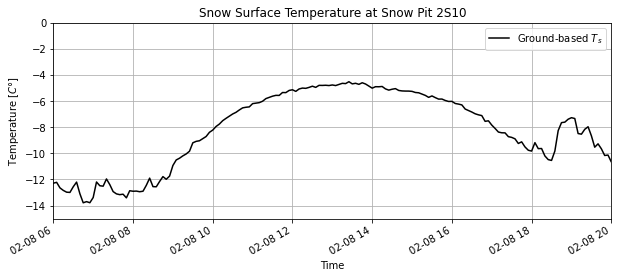

In [27]:
plt.figure(figsize=(10,4))

# plot radiometer average temperature
df.rad_avg.plot(linestyle='-', marker='', markersize=1, c='k', label='Ground-based $T_s$')

# set axes limits
plt.ylim((-15,0)) # set some temperature y-axis limts for our plot
plt.xlim((pd.Timestamp(2020,2,8,6,0),pd.Timestamp(2020,2,8,20,0))) # zoom in to daytime hours on Feb. 8, 2020

# add a legend to the plot
plt.legend()

# set axes labels
plt.ylabel('Temperature [$C\degree$]')
plt.xlabel('Time')

# add grid lines to the plot
plt.grid('on')

# set the plot title
plt.title('Snow Surface Temperature at Snow Pit 2S10');

---

## Compare Airborne IR against the "ground truth" snow surface temperature

**What is the temperature at this point in the airborne IR image?**

Use rioxarray's [clip](https://corteva.github.io/rioxarray/stable/examples/clip_geom.html) function to extract the raster values that intersect with the point's geometry. Because we have a point, this will return a single value for the pixel that overlaps this point.

In [28]:
# clip using our point's geometry
airborne_ir_point_temperature = airborne_ir.rio.clip(siteData_df.geometry)

# preview the result
airborne_ir_point_temperature

<xarray.DataArray (band: 1, y: 1, x: 1)>
array([[[-5.038153]]], dtype=float32)
Coordinates:
  * y            (y) float64 4.323e+06
  * x            (x) float64 7.431e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('STCtemp',)
    AREA_OR_POINT:  Area
    description:    Airborne thermal infrared imagery from University of Wash...
    grid_mapping:   spatial_ref
    _FillValue:     nan

Our result is a DataArray with a single data value at one set of x and y coordinates.


:::{admonition} Pixel = Point ?

Should we expect that the temperature measured for an image pixel would be the same for an individual point on the ground? The airborne imagery is at 5 meter spatial resolution, whereas our ground-based radiometer measured a spot maybe only ~1 m in diameter. Additionally, the geolocation of the airborne imagery is less accurate than 5 meters (closer to 10-15 meters) meaning that if we picked a single pixel to overlap our ground point, it may be the wrong pixel. Let's instead look at the average and distribution of temperatures from the airborne imagery in an area around this point.

:::

Add a 100 m radius [buffer](https://geopandas.org/docs/reference/api/geopandas.GeoSeries.buffer.html) around this point and get the temperature from the airborne imagery for a larger area around the snow pit.

In [29]:
r = 100 # radius of the buffer in meters (this is in meters because we are working in a UTM coordinate reference system)

# create the buffered geometry
siteData_df_buffer = siteData_df.buffer(r)

# preview the resulting geometry, we should see this is a POLYGON now
siteData_df_buffer

0    POLYGON ((743176.000 4322689.000, 743175.518 4...
dtype: geometry

What does this polygon look like when we plot it ontop of the airborne IR image now?

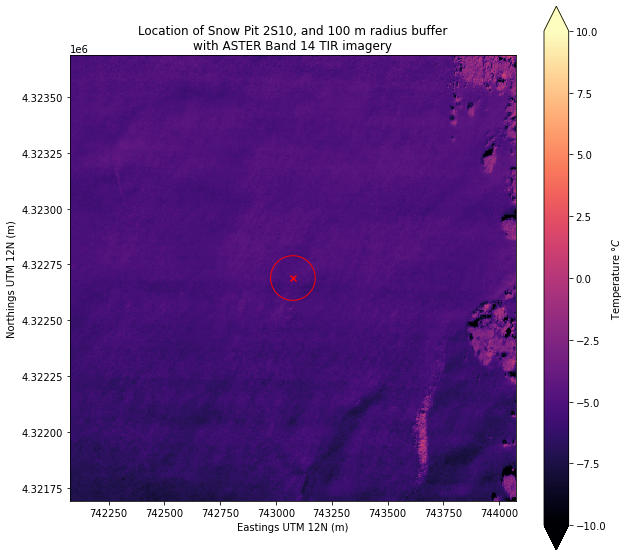

In [30]:
fig, ax = plt.subplots(figsize=(10,10)) # create a new matplotlib figure, set the figure size
ax.set_aspect('equal') # set the aspect ratio to "equal"

# plot the airborne infrared image
airborne_ir.plot(cmap='magma', vmin=-10, vmax=10, ax=ax, 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})

# plot the location of the snow pit of interest
siteData_df.plot(ax=ax, color='r', marker='x')

# plot the area of the buffer we made around the snow pit
siteData_df_buffer.plot(ax=ax, edgecolor='r', facecolor='none')

# set the same axes limits as above
ax.set_xlim((xmin-1000, xmax+1000)) # x axis limits to +/- 1 km from our point's "total bounds"
ax.set_ylim((ymin-1000, ymax+1000)) # y axis limits to +/- 1 km from our point's "total bounds"

# set axes labels
ax.set_xlabel('Eastings UTM 12N (m)')
ax.set_ylabel('Northings UTM 12N (m)')

# set plot title
ax.set_title('Location of Snow Pit 2S10, and 100 m radius buffer\nwith ASTER Band 14 TIR imagery');

Clip the airborne IR raster again, now with our 200 m diameter polygon around the snow pit site.

In [31]:
# clip using our new geometry
airborne_ir_area_temperature = airborne_ir.rio.clip(siteData_df_buffer.geometry)

# preview the result
airborne_ir_area_temperature

<xarray.DataArray (band: 1, y: 40, x: 40)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 4.323e+06 4.323e+06 ... 4.323e+06 4.323e+06
  * x            (x) float64 7.43e+05 7.43e+05 7.43e+05 ... 7.432e+05 7.432e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('STCtemp',)
    AREA_OR_POINT:  Area
    description:    Airborne thermal infrared imagery from University of Wash...
    grid_mapping:   spatial_ref
    _FillValue:     nan

The result of clipping is again a DataArray, this time though it is 40x40. We can plot this to see what it looks like, and to see the distribution of temperatures in the area.

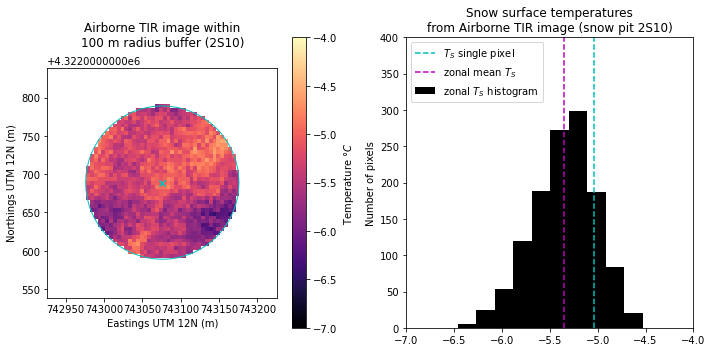

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), tight_layout=True)

# plot the portion of the airborne TIR image we selected within the buffer area geometry
airborne_ir_area_temperature.plot(cmap='magma', vmin=-7, vmax=-4, ax=ax[0], 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})
ax[0].set_title('Airborne TIR image within\n100 m radius buffer (2S10)\n')
ax[0].set_aspect('equal')
ax[0].set_xlabel('Eastings UTM 12N (m)')
ax[0].set_ylabel('Northings UTM 12N (m)')
ax[0].set_xlim((xmin-150, xmax+150)) # x axis limits to +/- 150 m from our point's "total bounds"
ax[0].set_ylim((ymin-150, ymax+150)) # y axis limits to +/- 150 m from our point's "total bounds"

# plot the location of the snow pit of interest to the plot
siteData_df.plot(ax=ax[0], color='c', marker='x')

# plot the area of the buffer we made around the snow pit
siteData_df_buffer.plot(ax=ax[0], edgecolor='c', facecolor='none')

# plot a histogram of image temperature data within the buffer area geometry
airborne_ir_area_temperature.plot.hist(ax=ax[1],
                                       color='k', 
                                       zorder=1, # use zorder to make sure this plots below the point
                                       label='zonal $T_S$ histogram') 

# plot a vertical line for the single-pixel temperature we think is right at the snow pit
ax[1].axvline(airborne_ir_point_temperature, 
              color='c',linestyle='--',  # set color and style
              zorder=2, # use zorder to make sure this plots on top of the histogram
              label='$T_S$ single pixel') 

# plot a vertical line for the mean temperature within the buffer area geometry
ax[1].axvline(airborne_ir_area_temperature.mean(), 
              color='m',linestyle='--',  # set color and style
              zorder=2, # use zorder to make sure this plots on top of the histogram
              label='zonal mean $T_S$') 

ax[1].legend(loc='upper left') # add a legend
ax[1].set_xlim((-7,-4)) # set xlim to same values as colorbar in image plot
ax[1].set_ylim((0,400)) # set ylim
ax[1].set_title('Snow surface temperatures\nfrom Airborne TIR image (snow pit 2S10)')
ax[1].set_ylabel('Number of pixels');

:::{admonition} What do these plots tell us about the surface temperature around the snow pit as measured by the airborn IR cameras?
:class: dropdown
* Is the snow surface temperature more variable or uniform in this area?
  * Note that we changed the minimum and maximum values of our colorbar!
  * Try computing the standard deviation of temperatures in this area
* How does our single pixel at the center compare with the rest of this area?
  * Try taking the mean or median of all temperatures in the area and compare against the single point. What is the difference?
* See [Lundquist et al., 2018](https://doi.org/10.1016/j.rse.2018.03.001) for an application of these methods with airborne and MODIS thermal infrared imagery
:::

**Plot the airborne IR temperature data on top of the ground-based timeseries**

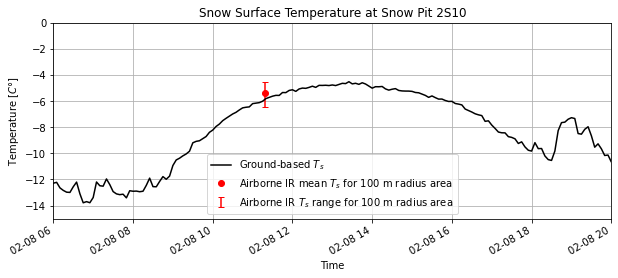

In [33]:
plt.figure(figsize=(10,4))

# plot radiometer average temperature
df.rad_avg.plot(linestyle='-', marker='', markersize=1, c='k', label='Ground-based $T_s$')

# plot the mean airborne IR temperature from the area around the snow pit:
plt.plot(airborne_ir_timestamp, airborne_ir_area_temperature.mean(),
         marker='o', c='r', linestyle='none',
         label='Airborne IR mean $T_s$ for 100 m radius area')

# plot an error bar showing the maximum and minimum airborne IR temperature around the snow pit
plt.errorbar(airborne_ir_timestamp, airborne_ir_area_temperature.mean(),
             yerr=[[airborne_ir_area_temperature.mean()-airborne_ir_area_temperature.min()], 
                   [airborne_ir_area_temperature.max()-airborne_ir_area_temperature.mean()]],
            capsize=3, fmt='none', ecolor='r',
            label='Airborne IR $T_s$ range for 100 m radius area')


# set axes limits
plt.ylim((-15,0))
plt.xlim((pd.Timestamp(2020,2,8,6,0),pd.Timestamp(2020,2,8,20,0))) # zoom in to daytime hours on Feb. 8, 2020

# add a legend to the plot
plt.legend()

# set axes labels
plt.ylabel('Temperature [$C\degree$]')
plt.xlabel('Time')

# add grid lines to the plot
plt.grid('on')

# set the plot title
plt.title('Snow Surface Temperature at Snow Pit 2S10');

:::{admonition} Continuing with this analysis:
:class: dropdown
In the above plot we've added "error bars" to represent the full range of temperatures within the 100 m radius area around the snow pit. 
* Is this a fair comparison? 
* Should we make the area smaller based on our confidence in the image's geolocation accuracy (10-15 m)?
* What is the difference between the "ground truth" data and the airborne IR data at this point in time?
:::

---

# Part 2: Satellite IR remote sensing obsevations

## Satellite IR imagery with ASTER

**Advantages of satellite IR images:** We don't always have airplanes with IR cameras flying around. Satellites can provide images at more regular intervals for long-term studies, and can see areas that are difficult to access on the ground or by air.

:::{admonition} What might be some diadvantages of satellite IR imagery compared to airborne IR imagery?
:class: dropdown
- Lower spatial resolution because they're further away from the Earth's surface
- Mixed pixel problem: with lower image resolutions, each pixel contains a more heterogeneous mixtures of surfaces and temperatures, meaning that temperature information is more blurred together
- What other disadvantages can you think of? 
- How might these differences (advantages or disadvantages) change the type of research questions you can investigate?
:::

For this tutorial, we will look at an image from NASA's [Advanced Spaceborne Thermal Emission and Reflection Radiometer](https://asterweb.jpl.nasa.gov/) (ASTER) imager, which is onboard the Terra satellite along with a MODIS imager. We can compare an ASTER IR image of Grand Mesa that was taken at roughly the same time as the airborne IR image. The ASTER image we will be working with is from ASTER's [band 14](https://asterweb.jpl.nasa.gov/characteristics.asp) which is sensitive to radiance in the 10.95-11.65 µm wavelength range.

Load an ASTER geotiff that we've downloaded for this tutorial, and inspect its contents.

In [34]:
aster_ir = xr.open_rasterio('/tmp/thermal-ir/AST_L1T_00302082020180748_20200209065849_17218_ImageData14.tif')

In [35]:
aster_ir

<xarray.DataArray (band: 1, y: 817, x: 927)>
[757359 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.357e+06 4.356e+06 4.356e+06 ... 4.283e+06 4.283e+06
  * x        (x) float64 6.998e+05 6.998e+05 6.999e+05 ... 7.83e+05 7.831e+05
Attributes:
    transform:      (90.0, 0.0, 699705.0, 0.0, -90.0, 4356585.0)
    crs:            +init=epsg:32612
    res:            (90.0, 90.0)
    is_tiled:       0
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

When was this image taken?

In [36]:
aster_ir_timestamp = pd.Timestamp(2020,2,8,18,7,48) - pd.Timedelta(hours=7)

Plot the image. What are the units of the values on the colorbar?

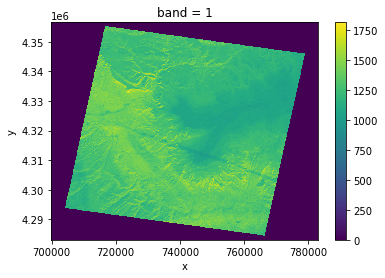

In [37]:
aster_ir.plot()

It's necessary to read the product documentation to understand what we are looking at here. 

We are using the *ASTER Level 1 Precision Terrain Corrected Registered At-Sensor Radiance* (AST_L1T) product. [Product documentation is available here](https://lpdaac.usgs.gov/products/ast_l1tv003/). Also helpful is the ** (AST_L1B) [product documentation here](https://lpdaac.usgs.gov/products/ast_l1bv003/) from which AST_L1T is derived.

The values here are stored as scaled "digital number" (DN) values rather than the actual radiance values. The product documentation also provides information about how to unscale these values back into radiance units, and from radiance to brightness temperature, using laboratory calibrated constants.

I've written two functions here to do this unit conversion for the five ASTER TIR bands in two steps (DN to radiance, radiance to brightness temperature). The function takes as its arguments the DN or radiance values respectivly, and the band number (in our case band number `14`, *not the band wavelengths*).

In [38]:
def tir_dn2rad(DN, band):
    '''Convert AST_L1T Digital Number values to At-Sensor Radiance for the TIR bands (bands 10-14).'''
    ucc = [6.822e-3, 6.780e-3, 6.590e-3, 5.693e-3, 5.225e-3]
    rad = (DN-1.) * ucc[band-10]
    return rad

def tir_rad2tb(rad, band):
    '''Convert AST_L1T At-Sensor Radiance to Brightness Temperature [K] for the TIR bands (bands 10-14).'''
    k1 = [3047.47, 2480.93, 1930.80, 865.65, 649.60]
    k2 = [1736.18, 1666.21, 1584.72,1349.82, 1274.49]
    tb = k2[band-10] /  np.log((k1[band-10]/rad) + 1)
    return tb

Use the above functions to convert from DN to radiance, radiance to brightness temperature (assume and emissivity of 1 for all surfaces, note that the airborne imagery also assumed emissivity of 1).

Then convert from degeees K to degrees C by subtracting 273.15.

In [39]:
aster_band14_rad = tir_dn2rad( aster_ir, band=14 ) # convert from DN to radiance
aster_band14_tb_k = tir_rad2tb( aster_band14_rad, band=14 ) # convert from radiance to brightness temperature (K)
aster_band14_tb_c = aster_band14_tb_k - 273.15 # convert from K to C

# Note that an "invalid value encountered..." warning may pop up here. This is because the above function tries to take the log of "nan" values that are outside the imaged area
# we can ingnore this warning and proceed

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


During this unit conversion, xarray dropped the coordinate reference system attributes, so here we add the original crs to the new ASTER degrees celcius dataarray.

In [40]:
aster_band14_tb_c.rio.set_crs(aster_ir.crs, inplace=True);

Plot our image again, this time setting our colorscale and colorbar values. We should see "realistic" surface temperature values in degrees C now.

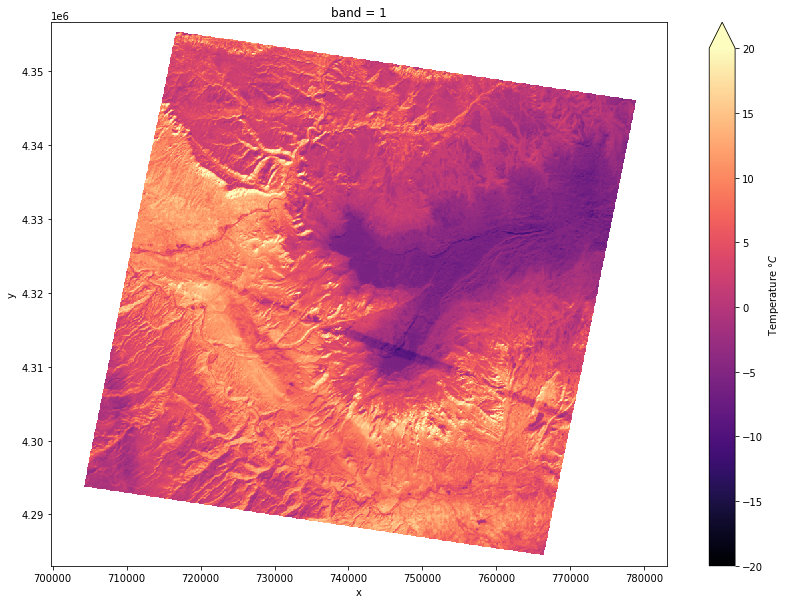

In [41]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_aspect('equal')
aster_band14_tb_c.plot(ax=ax,
                       cmap='magma', 
                       vmin=-20, vmax=20, # note that we have a wider temperature range on our colorbar for this image, -20 to +20 C instead of -10 to +10 C
                       cbar_kwargs={'label': 'Temperature $\degree C$'})

:::{admonition} Image interpretation
:class: hint
* What does our chosen colorscale tell us about temperatures here?
* What can we see?
  * What do you think that cold linear feature across the image is? (Hint: think about the cold object we saw in the airborne IR image)
:::

**Plot ASTER next to Airborne IR to see spatial resolution differences**



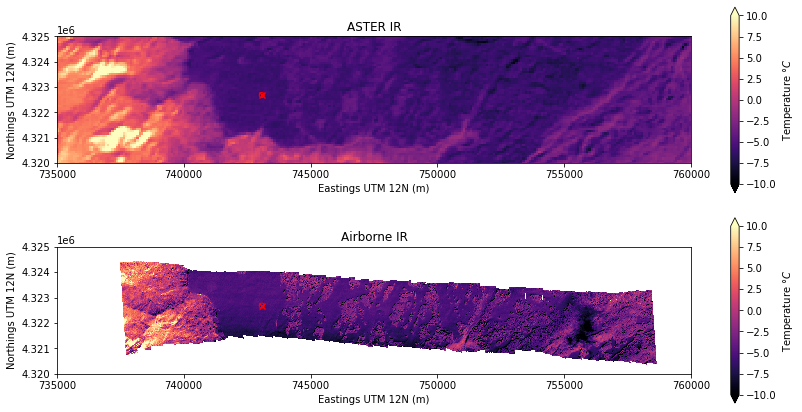

In [42]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,6), tight_layout=True)

aster_band14_tb_c.plot(ax=axs[0], 
                       cmap='magma', 
                       vmin=-10, vmax=10, 
                       cbar_kwargs={'label': 'Temperature $\degree C$'})
axs[0].set_title('ASTER IR')
axs[0].set_aspect('equal')


airborne_ir.plot(ax=axs[1], 
                 cmap='magma', 
                 vmin=-10, vmax=10, 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})
axs[1].set_title('Airborne IR')
axs[1].set_aspect('equal')

# for each subplot, do the following:
for ax in axs: 
    ax.set_aspect('equal') # set the aspect ratio to "equal"
    
    # plot the location of the snow pit of interest
    siteData_df.plot(ax=ax, color='r', marker='x')
    # plot the area of the buffer we made around the snow pit
    siteData_df_buffer.plot(ax=ax, edgecolor='r', facecolor='none')
    
    # set axes labels and limits
    ax.set_xlabel('Eastings UTM 12N (m)')
    ax.set_xlim((735000, 760000))
    ax.set_ylabel('Northings UTM 12N (m)')
    ax.set_ylim((4320000, 4325000))

Make another plot to zoom in on snow pit 2S10:

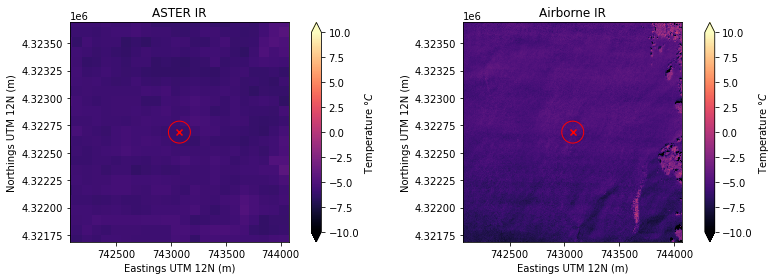

In [43]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4), tight_layout=True)

aster_band14_tb_c.plot(ax=axs[0], 
                       cmap='magma', 
                       vmin=-10, vmax=10, 
                       cbar_kwargs={'label': 'Temperature $\degree C$'})
axs[0].set_title('ASTER IR')
axs[0].set_aspect('equal')


airborne_ir.plot(ax=axs[1], 
                 cmap='magma', 
                 vmin=-10, vmax=10, 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})
axs[1].set_title('Airborne IR')
axs[1].set_aspect('equal')

# for each subplot, do the following:
for ax in axs: 
    ax.set_aspect('equal') # set the aspect ratio to "equal"
    
    # plot the location of the snow pit of interest
    siteData_df.plot(ax=ax, color='r', marker='x')
    # plot the area of the buffer we made around the snow pit
    siteData_df_buffer.plot(ax=ax, edgecolor='r', facecolor='none')
    
    # set axes labels
    ax.set_xlabel('Eastings UTM 12N (m)')
    ax.set_ylabel('Northings UTM 12N (m)')
    # set the same axes limits as above
    ax.set_xlim((xmin-1000, xmax+1000)) # x axis limits to +/- 1 km from our point's "total bounds"
    ax.set_ylim((ymin-1000, ymax+1000)) # y axis limits to +/- 1 km from our point's "total bounds"

Get the temperature of the ASTER pixel at the snow pit point using rioxarray [clip](https://corteva.github.io/rioxarray/stable/examples/clip_geom.html).

In [44]:
# First clip to the single point
aster_band14_tb_c_point_temperature = aster_band14_tb_c.rio.clip(siteData_df.geometry)

# Second clip to the 100 m radius buffered area
aster_band14_tb_c_area_temperature = aster_band14_tb_c.rio.clip(siteData_df_buffer.geometry)

# preview the result
aster_band14_tb_c_area_temperature

<xarray.DataArray (band: 1, y: 2, x: 2)>
array([[[-6.08382303, -6.1361369 ],
        [-6.0315384 , -6.24085249]]])
Coordinates:
  * y            (y) float64 4.323e+06 4.323e+06
  * x            (x) float64 7.43e+05 7.431e+05
  * band         (band) int64 1
    spatial_ref  int64 0

How many ASTER pixels in the area did we select?

Plot the clipped area:

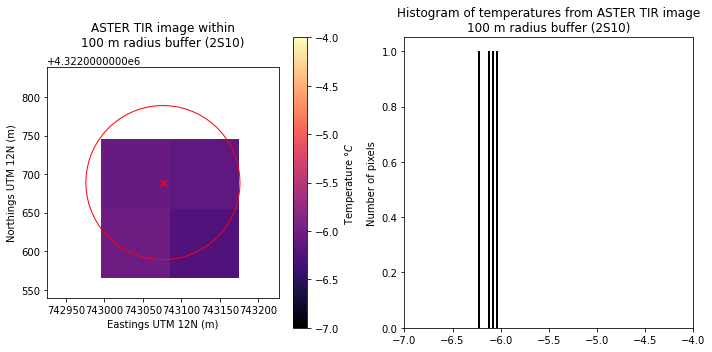

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), tight_layout=True)

# plot the portion of the airborne TIR image we selected within the buffer area geometry
aster_band14_tb_c_area_temperature.plot(cmap='magma', vmin=-7, vmax=-4, ax=ax[0], 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})
ax[0].set_title('ASTER TIR image within\n100 m radius buffer (2S10)\n')
ax[0].set_aspect('equal')
ax[0].set_xlabel('Eastings UTM 12N (m)')
ax[0].set_ylabel('Northings UTM 12N (m)')
ax[0].set_xlim((xmin-150, xmax+150)) # x axis limits to +/- 150 m from our point's "total bounds"
ax[0].set_ylim((ymin-150, ymax+150)) # y axis limits to +/- 150 m from our point's "total bounds"

# plot the location of the snow pit of interest to the plot
siteData_df.plot(ax=ax[0], color='r', marker='x')

# plot the area of the buffer we made around the snow pit
siteData_df_buffer.plot(ax=ax[0], edgecolor='r', facecolor='none')

# plot a histogram of image temperature data within the buffer area geometry
aster_band14_tb_c_area_temperature.plot.hist(ax=ax[1], color='k');
ax[1].set_xlim((-7,-4)) # set xlim to same values as colorbar in image plot
ax[1].set_title('Histogram of temperatures from ASTER TIR image\n100 m radius buffer (2S10)')
ax[1].set_ylabel('Number of pixels');

**Plot the ASTER IR temperature data on top of the ground-based timeseries and airborne IR temperature**

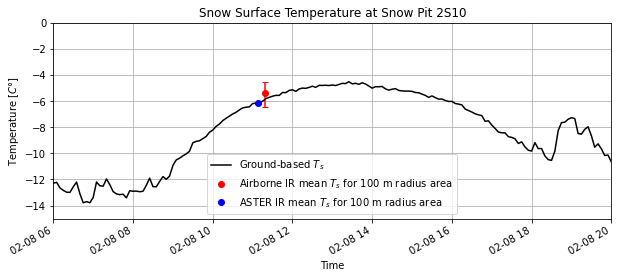

In [46]:
plt.figure(figsize=(10,4))

# plot radiometer average temperature
df.rad_avg.plot(linestyle='-', marker='', markersize=1, c='k', label='Ground-based $T_s$')

# plot the mean airborne IR temperature from the area around the snow pit:
plt.plot(airborne_ir_timestamp, airborne_ir_area_temperature.mean(),
         marker='o', c='r', linestyle='none',
         label='Airborne IR mean $T_s$ for 100 m radius area')
# plot an error bar showing the maximum and minimum airborne IR temperature around the snow pit
plt.errorbar(airborne_ir_timestamp, airborne_ir_area_temperature.mean(),
             yerr=[[airborne_ir_area_temperature.mean()-airborne_ir_area_temperature.min()], 
                   [airborne_ir_area_temperature.max()-airborne_ir_area_temperature.mean()]],
            capsize=3, fmt='none', ecolor='r',
            )#label='Airborne IR $T_s$ range for 100 m radius area')

# plot the mean ASTER IR temperature from the area around the snow pit:
plt.plot(aster_ir_timestamp, aster_band14_tb_c_area_temperature.mean(),
         marker='o', c='b', linestyle='none',
        label='ASTER IR mean $T_s$ for 100 m radius area')
# plot an error bar showing the maximum and minimum ASTER IR temperature around the snow pit
plt.errorbar(aster_ir_timestamp, aster_band14_tb_c_area_temperature.mean(),
             yerr=[[aster_band14_tb_c_area_temperature.mean()-aster_band14_tb_c_area_temperature.min()], 
                   [aster_band14_tb_c_area_temperature.max()-aster_band14_tb_c_area_temperature.mean()]],
            capsize=3, fmt='none', ecolor='b',
            )#label='ASTER IR $T_s$ range for 100 m radius area')


# set axes limits
plt.ylim((-15,0))
plt.xlim((pd.Timestamp(2020,2,8,6,0),pd.Timestamp(2020,2,8,20,0))) # zoom in to daytime hours on Feb. 8, 2020

# add a legend to the plot
plt.legend()

# set axes labels
plt.ylabel('Temperature [$C\degree$]')
plt.xlabel('Time')

# add grid lines to the plot
plt.grid('on')

# set the plot title
plt.title('Snow Surface Temperature at Snow Pit 2S10');

---
### Bonus activity: comparing two thermal IR rasters

How does the finer spatial resolution airborne IR image compare with the coarser resolution ASTER IR image?

One way to compare these two images is to "upscale" the finer resolution airborne IR image to the same spatial resolution as ASTER.

We can use the rioxarray [reproject_match](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray.raster_array.RasterArray.reproject_match) function to do this. ([also see this example](https://corteva.github.io/rioxarray/stable/examples/reproject_match.html))

Note that this function has [multiple options](https://rasterio.readthedocs.io/en/stable/api/rasterio.enums.html#rasterio.enums.Resampling) for how we want to resample the image data to the new spatial resolution. We will use `resampling=5` which corresponds to taking the mean value.

In [47]:
airborne_ir_repr = airborne_ir.rio.reproject_match(aster_ir, resampling=5)

Preview the result. 
* What are the image dimensions of the reprojected airborne IR image compared with the original?

In [48]:
airborne_ir_repr

<xarray.DataArray (band: 1, y: 817, x: 927)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 6.998e+05 6.998e+05 ... 7.83e+05 7.831e+05
  * y            (y) float64 4.357e+06 4.356e+06 ... 4.283e+06 4.283e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('STCtemp',)
    AREA_OR_POINT:  Area
    description:    Airborne thermal infrared imagery from University of Wash...
    grid_mapping:   spatial_ref
    _FillValue:     nan

Plot the ASTER image, original airborne IR image, and resampled airborne IR image next to each other to visualize these spatial resolution differences.

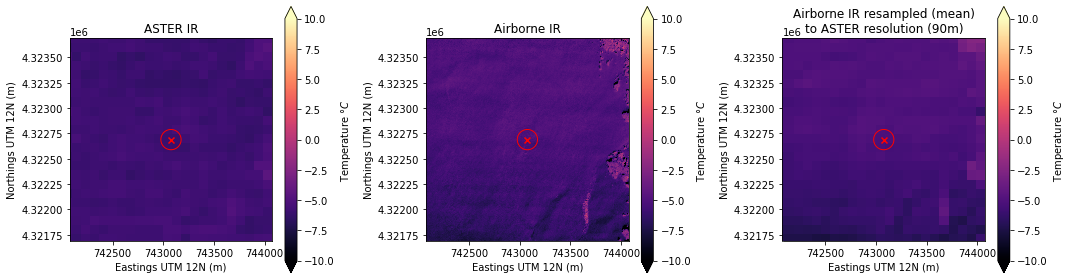

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,4), tight_layout=True)

# ASTER IR image
aster_band14_tb_c.plot(ax=axs[0], 
                       cmap='magma', 
                       vmin=-10, vmax=10, 
                       cbar_kwargs={'label': 'Temperature $\degree C$'})
axs[0].set_title('ASTER IR')
axs[0].set_aspect('equal')

# Original airborne IR image
airborne_ir.plot(ax=axs[1], 
                 cmap='magma', 
                 vmin=-10, vmax=10, 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})
axs[1].set_title('Airborne IR')
axs[1].set_aspect('equal')

# Resampled airborne IR image
airborne_ir_repr.plot(ax=axs[2], 
                      cmap='magma', 
                      vmin=-10, vmax=10, 
                      cbar_kwargs={'label': 'Temperature $\degree C$'})
axs[2].set_title('Airborne IR resampled (mean)\nto ASTER resolution (90m)')
axs[2].set_aspect('equal')


# for each subplot, do the following:
for ax in axs: 
    ax.set_aspect('equal') # set the aspect ratio to "equal"
    
    # plot the location of the snow pit of interest
    siteData_df.plot(ax=ax, color='r', marker='x')
    # plot the area of the buffer we made around the snow pit
    siteData_df_buffer.plot(ax=ax, edgecolor='r', facecolor='none')
    
    # set axes labels
    ax.set_xlabel('Eastings UTM 12N (m)')
    ax.set_ylabel('Northings UTM 12N (m)')
    # set the same axes limits as above
    ax.set_xlim((xmin-1000, xmax+1000)) # x axis limits to +/- 1 km from our point's "total bounds"
    ax.set_ylim((ymin-1000, ymax+1000)) # y axis limits to +/- 1 km from our point's "total bounds"

Finally, compute the difference between the ASTER IR image and resampled airborne IR image, then plot the result:

In [50]:
# Subtract reprojected airborne IR image from ASTER IR image
difference_image = aster_band14_tb_c - airborne_ir_repr

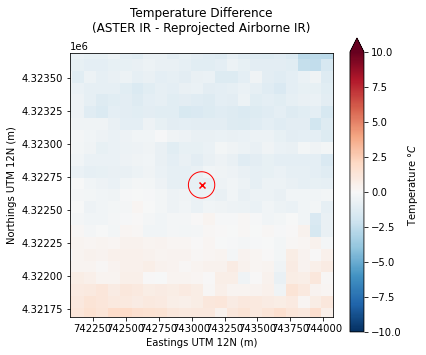

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5), tight_layout=True)

# Difference image
difference_image.plot(ax=ax, 
                       cmap='RdBu_r', 
                       vmin=-10, vmax=10, 
                       cbar_kwargs={'label': 'Temperature $\degree C$'})
ax.set_title('Temperature Difference\n(ASTER IR - Reprojected Airborne IR)\n')
ax.set_aspect('equal')

# plot the location of the snow pit of interest
siteData_df.plot(ax=ax, color='r', marker='x')
# plot the area of the buffer we made around the snow pit
siteData_df_buffer.plot(ax=ax, edgecolor='r', facecolor='none')

# set axes labels
ax.set_xlabel('Eastings UTM 12N (m)')
ax.set_ylabel('Northings UTM 12N (m)')
# set the same axes limits as above
ax.set_xlim((xmin-1000, xmax+1000)) # x axis limits to +/- 1 km from our point's "total bounds"
ax.set_ylim((ymin-1000, ymax+1000)); # y axis limits to +/- 1 km from our point's "total bounds"

---
# Next steps:

## Project ideas with these data:
* Compare more snow pit temperature data (using snowexsql queries) against airborne and satellite IR imagery
* Investigate spatial patterns of snow temperature from open areas to forested areas on the mesa, differences between ASTER and airborne IR imagery
* Improved data visualization using [hvplot](https://hvplot.holoviz.org/) or something similar to create interactive plots of IR and/or visible imagery
* Compare thermal infrared and SAR imagery, or snow temperature observations and snow model outputs

:::{note}
*Contact Steven Pestana during the hackweek for help accessing more airborne IR or visible imagery and related datasets*
:::

## Data access/download and pre-processing
See the jupyter notebook "[thermal-ir-data-download.ipynb](thermal-ir-data-download.ipynb)" for more details about data access methods through the NASA EarthData API, and pre-processing ASTER data into geotiff images.

## Additional learning resources:
:::{seealso}

**[NumPy]() learning resources:**
* [NumPy and the ndarray](https://github.com/waterhackweek/waterdata/blob/master/gridded_data_tutorial_0.ipynb)
* [NumPy: the absolute basics for beginners](https://numpy.org/devdocs/user/absolute_beginners.html)
* [NumPy: creating and manipulating numerical data](https://scipy-lectures.org/intro/numpy/index.html)
* [Advanced NumPy](https://scipy-lectures.org/advanced/advanced_numpy/index.html)
* [NumPy for MATLAB users](https://numpy.org/doc/stable/user/numpy-for-matlab-users.html)

**[Xarray](https://xarray.pydata.org/en/stable/) and [rioxarray](https://corteva.github.io/rioxarray/stable/) learning resources:**
* [Introduction to xarray](https://github.com/waterhackweek/waterdata/blob/master/gridded_data_tutorial_1.ipynb)
* [GeoHackWeek 2019 raster tools](https://github.com/geohackweek/raster-2019)
* [rasterio](https://rasterio.readthedocs.io/en/latest/)
* [cartopy](https://scitools.org.uk/cartopy/docs/latest/)

**[ASTER](https://asterweb.jpl.nasa.gov/) resources:**
* [ASTER L1T Scripts and Tutorials](https://git.earthdata.nasa.gov/projects/LPDUR/repos/aster-l1t/browse)
* [Validating ASTER Thermal Infrared Imaging for use in Snow Models](https://github.com/UW-GDA/aster-thermal/)
:::